# Setup

# Work here

In [1]:

import pickle
import random
import numpy as np

import theano
import theano.tensor as T
import lasagne

from collections import Counter
from lasagne.utils import floatX

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 4007)


Download the data set

In [2]:
#!wget https://s3.amazonaws.com/lasagne/recipes/datasets/coco_with_cnn_features.pkl

Load the dataset

In [3]:
dataset = pickle.load(open('coco_with_cnn_features.pkl')) #This is a list of dictionaries

In [4]:
dataset[2].keys()

[u'filepath',
 'cnn features',
 u'sentids',
 u'filename',
 u'imgid',
 u'split',
 u'sentences',
 u'cocoid']

In [5]:
allwords = Counter()
for item in dataset:
    for sentence in item['sentences']:
        allwords.update(sentence['tokens'])
        
vocab = [k for k, v in allwords.items() if v >= 5] #Finding words that occure more than 5 times
vocab.insert(0, '#START#')
vocab.append('#END#')

word_to_index = {w: i for i, w in enumerate(vocab)} #Dic with word as key and index as value
index_to_word = {i: w for i, w in enumerate(vocab)} #Dic with index as key and word as value

In [6]:
SEQUENCE_LENGTH = 32
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token (This means that we can at most have a caption of length 29 + start and end token)
BATCH_SIZE = 100
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 512

In [7]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, split='train'): #dataset, size=batch_size(100)
    items = []
    
    while len(items) < size:
        item = random.choice(dataset) #While data less than batch_size, choose a random datapoint
        if item['split'] != split: 
            continue
        sentence = random.choice(item['sentences'])['tokens'] #Choose a random caption from the data point
        if len(sentence) > MAX_SENTENCE_LENGTH: #Check that that caption is not longer than max sentence length
            continue
        items.append((item['cnn features'], sentence, item['cocoid'])) #Add the cnn features, sentence and id to the batch
    
    return items #Returns the batch which is a list consisting of tuples (it should be the same length as size?)

In [8]:
# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1000))) #batch_size X 1000 (1000 is the number of cnn features)
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32') #batch_size x 31 (which is  the max length of a sentence if we include start and stop characters)
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32') #Why is this one longer?
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool') #What is mask?

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        mask[j, 0] = False
        
    
                
    return x_cnn, x_sentence, y_sentence, mask

### VAE-multz

from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import rectify, sigmoid
from samplelayer import SimpleSampleLayer, SampleLayer

num_features = x_train.shape[-1]
num_latent_z = 2
R = 10
#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_enc = DenseLayer(l_in_x, num_units=128, nonlinearity=rectify)
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=None)                           #(BS, num_latent_z) 
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #(BS, num_latent_z) 
l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq)  #(BS, num_latent_z)  , eq_samples=1
l_z = SampleLayer(mean=l_muq, log_var=l_logvarq, eq_samples=10)  #(BS*eq_samples, num_latent_z)  , eq_samples=10

#sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#we split the model into two parts to allow sampling from the decoder model separately
#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = DenseLayer(l_in_z, num_units=128, nonlinearity=rectify) 
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #(BS*eq_samples, num_features) 

In [9]:
import parmesan

In [43]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import rectify, sigmoid
#from samplelayer import SimpleSampleLayer, SampleLayer
from parmesan.layers import SimpleSampleLayer, SampleLayer

num_latent_z = 32

### ENCODER STARTS ###
## Enocding the captions
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1),input_var=T.imatrix()) #Batch size time the length of the caption
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

print('Shapes:')
print('l_input_sentence')
print(l_input_sentence.shape)
print('l_sentence_embedding')
print(l_sentence_embedding.output_shape)
# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE)) #Batch size times 100
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity) #Resize the cnn to embdding_size (512 i belive)

print('l_cnn_embedding')
print(l_cnn_embedding.output_shape)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1])) #Reshape the embedding to ...

print('l_input_cnn')
print(l_input_cnn.shape)
print('l_cnn_embedding')
print(l_cnn_embedding.output_shape)


# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
### DECODER STARTS##

l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding]) 
print('l_rnn_input')
print(l_rnn_input.output_shape)
###Adding new layers
l_muq = DenseLayer(l_rnn_input, num_units=num_latent_z, nonlinearity=None)                           #(BS, num_latent_z) 
l_logvarq = DenseLayer(l_rnn_input, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10))

l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq)  #(BS, num_latent_z)  , eq_samples=1
#l_z = SampleLayer(mean=l_muq, log_var=l_logvarq, eq_samples=10)  #(BS*eq_samples, num_latent_z)  , eq_samples=10
print('l_muq')
print(l_muq.output_shape)
print('l_logvarq')
print(l_logvarq.output_shape)
print('l_z')
print(l_z.output_shape)

#l_in_z = InputLayer(shape=(None, num_latent_z))
###RNN
#l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
#l_dropout_input = lasagne.layers.DropoutLayer(l_z, p=0.5)
l_dropout_input = InputLayer(shape=(None, len(vocab)))
#l_dec_embedding = lasagne.layers.EmbeddingLayer(l_dropout_input,
#                                                     input_size=len(vocab),
#                                                     output_size=EMBEDDING_SIZE,
#                                                    )
#l_dec_embedding = lasagne.layers.DenseLayer(l_dropout_input, num_units=EMBEDDING_SIZE, nonlinearity=None)
#l_dec_embedding = lasagne.layers.RecurrentLayer(l_dropout_input, num_units=EMBEDDING_SIZE, nonlinearity=None)

#lstm needs a 3D layer as input!!!!!!

l_decode_embedding = lasagne.layers.ReshapeLayer(l_dropout_input, ([0], 1, [1])) 

l_lstm = lasagne.layers.LSTMLayer(l_decode_embedding,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=False,
                                  grad_clipping=5.)

#l_lstm = lasagne.layers.LSTMLayer(l_dec_embedding,
#                                  num_units=EMBEDDING_SIZE,
#                                  unroll_scan=True,
#                                  grad_clipping=5.)

l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)


#print('l_dropout_input')
#print(l_dropout_input.output_shape)
#print('l_dec_embedding')
#print(l_dec_embedding.output_shape)
print('l_lstm')
print(l_lstm.output_shape)
print('l_dropout_output')
print(l_dropout_output.output_shape)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

print('l_shp')
print(l_shp.input_shape)
print(l_shp.output_shape)
print('l_decoder')
print(l_decoder.input_shape)
print(l_decoder.output_shape)
print('l_out')
print(l_out.input_shape)
print(l_out.output_shape)


Shapes:
l_input_sentence
(100, 31)
l_sentence_embedding
(100, 31, 512)
l_cnn_embedding
(100, 512)
l_input_cnn
(100, 1000)
l_cnn_embedding
(100, 1, 512)
l_rnn_input
(100, 32, 512)
l_muq
(100, 32)
l_logvarq
(100, 32)
l_z
(100, 32)
l_lstm
(None, 1, 512)
l_dropout_output
(None, 1, 512)
l_shp
(None, 1, 512)
(None, 512)
l_decoder
(None, 512)
(None, 10370)
l_out
(None, 10370)
(100, 32, 10370)


Shapes:
l_input_sentence
(100, 31)
l_sentence_embedding
(100, 31, 512)
l_input_cnn
(100, 1000)
l_cnn_embedding
(100, 1, 512)
l_rnn_input
(100, 32, 512)
l_dropout_input
(100, 32, 512)
l_lstm
(100, 32, 512)
l_dropout_output
(100, 32, 512)
l_shp
(3200, 512)
l_decoder
(3200, 10370)
l_out
(100, 32, 10370)


In [16]:
print(z_train.dtype)
print(sym_z.dtype)
print(mask_sym.dtype)

float32
float32
int32


In [46]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.matrix()

sym_z = T.matrix()

z_train, muq_train, logvarq_train = lasagne.layers.get_output([l_z,l_muq,l_logvarq],{
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                },deterministic=False)

##THE MUX's DO NOT WORK!!!!!!!!!!FML
### THE MUX, needs int(like mask_sym to work)

#mux_train = lasagne.layers.get_output(l_out,{l_dropout_input:z_train},deterministic=False)
#mux_train = lasagne.layers.get_output(l_out,{l_dropout_input:mask_sym},deterministic=False)

z_eval, muq_eval, logvarq_eval = lasagne.layers.get_output([l_z,l_muq,l_logvarq],{
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                },deterministic=True)
#mux_eval = lasagne.layers.get_output(l_out,{l_dropout_input:z_eval},deterministic=True)
#mux_eval = lasagne.layers.get_output(l_out,{l_dropout_input:mask_sym},deterministic=True)

#mux_sample = lasagne.layers.get_output(l_out,{l_dropout_input:sym_z},deterministic=True)
#mux_sample = lasagne.layers.get_output(l_out,{l_dropout_input:mask_sym},deterministic=True)

In [ ]:
print(z_eval)
print(muq_eval)
print(logvarq_eval)
print(x_sentence_sym)

In [68]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.imatrix()

In [21]:
output = lasagne.layers.get_output(l_out, {
                #l_input_sentence: x_sentence_sym,
                 l_input_sentence: mask_sym,
                 l_input_cnn: x_cnn_sym
                })

TypeError: index must be integers

In [22]:
def calc_cross_ent(net_output, mask, targets):
    # Helper function to calculate the cross entropy error
    preds = T.reshape(net_output, (-1, len(vocab)))
    targets = T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost

loss = T.mean(calc_cross_ent(mux_sample , mask_sym, y_sentence_sym))

TypeError: integer vector required for argument: true_one_of_n(got type: TensorType(float32, vector) instead of: TensorType(int64, vector))

In [20]:
MAX_GRAD_NORM = 15

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(loss, all_params)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_train = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym],
                          [loss, norm, output],
                          updates=updates
                         )

f_val = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym], [loss,output])

NameError: name 'loss' is not defined

In [ ]:
for iteration in range(20000):
    x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE))
    loss_train, norm,output = f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch)
            loss_val,output_val = f_val(x_cnn, x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
            image_nr = 1
            print [index_to_word[x] for x in x_sentence[image_nr]]
            print [index_to_word[np.argmax(x)] for x in output_val[image_nr]]
        except IndexError:
            continue    

In [19]:
[index_to_word[np.argmax(x)] for x in output_val[5]]

[u'assembling',
 u'a',
 u'man',
 u'is',
 u'is',
 u'sitting',
 u'at',
 u'a',
 u'laptop',
 u'in',
 '#END#',
 '#END#',
 '#END#',
 '#END#',
 '#END#',
 u'a',
 '#END#',
 u'a',
 '#END#',
 '#END#',
 '#END#',
 '#END#',
 '#END#',
 '#END#',
 '#END#',
 u'a',
 '#END#',
 '#END#',
 '#END#',
 u'a',
 '#END#',
 u'a']

In [115]:
image_nr = 20
print [index_to_word[x] for x in x_sentence[image_nr]]
print [index_to_word[np.argmax(x)] for x in output_val[image_nr]]

['#START#', u'a', u'pair', u'of', u'men', u'at', u'a', u'wedding', u'have', u'drinks', u'at', u'a', u'bar', '#END#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#', '#START#']
[u'a', u'a', u'cat', u'sitting', u'sitting', u'into', u'a', u'a', u'on', u'to', u'a', '#END#', '#END#', u'a', u'a', '#END#', '#END#', u'a', u'a', '#END#', u'a', u'a', '#END#', u'a', u'a', '#END#', u'a', u'a', u'a', u'a', u'a', u'a']


In [111]:
np.array(lasagne.layers.get_output(l_out, {l_input_sentence: dataset[0]['sentences'][0]['tokens'], l_input_cnn: dataset[0]['cnn features']}, deterministic=True).eval())

TypeError: Input of type <type 'str'> is not a Theano expression and cannot be wrapped as a Theano constant (original exception: ('Could not convert  to TensorType', <type 'str'>))

In [116]:
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [117]:
plt.imshow(dataset[0]['cnn features'])

TypeError: Invalid dimensions for image data

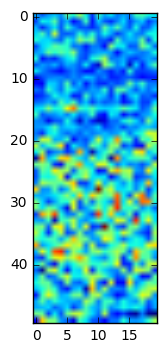

In [132]:
plt.imshow(dataset[3]['cnn features'].reshape(50,20))
plt.show()

In [133]:
dataset[3]['sentences']

[{u'imgid': 3,
  u'raw': u'A young boy standing in front of a computer keyboard.',
  u'sentid': 721981,
  u'tokens': [u'a',
   u'young',
   u'boy',
   u'standing',
   u'in',
   u'front',
   u'of',
   u'a',
   u'computer',
   u'keyboard']},
 {u'imgid': 3,
  u'raw': u'a little boy wearing headphones and looking at a computer monitor',
  u'sentid': 728503,
  u'tokens': [u'a',
   u'little',
   u'boy',
   u'wearing',
   u'headphones',
   u'and',
   u'looking',
   u'at',
   u'a',
   u'computer',
   u'monitor']},
 {u'imgid': 3,
  u'raw': u'He is listening intently to the computer at school.',
  u'sentid': 730555,
  u'tokens': [u'he',
   u'is',
   u'listening',
   u'intently',
   u'to',
   u'the',
   u'computer',
   u'at',
   u'school']},
 {u'imgid': 3,
  u'raw': u'A young boy stares up at the computer monitor.',
  u'sentid': 731665,
  u'tokens': [u'a',
   u'young',
   u'boy',
   u'stares',
   u'up',
   u'at',
   u'the',
   u'computer',
   u'monitor']},
 {u'imgid': 3,
  u'raw': u'a young kid w

In [33]:
[index_to_word[x] for x in y_sentence[0]]

['#START#',
 u'laptop',
 u'computer',
 u'displayed',
 u'on',
 u'chair',
 u'next',
 u'to',
 u'musical',
 u'instrument',
 '#END#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#']

In [34]:
[index_to_word[x] for x in x_sentence[0]]

['#START#',
 u'laptop',
 u'computer',
 u'displayed',
 u'on',
 u'chair',
 u'next',
 u'to',
 u'musical',
 u'instrument',
 '#END#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#',
 '#START#']

In [38]:
x_sentence[0] == y_sentence[0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


False

In [37]:
y_sentence

array([[   0, 9830, 8938, ...,    0,    0,    0],
       [   0, 5162, 9274, ...,    0,    0,    0],
       [   0, 8713, 5568, ...,    0,    0,    0],
       ..., 
       [   0, 8713, 8893, ...,    0,    0,    0],
       [   0, 6764, 9642, ...,    0,    0,    0],
       [   0, 6764, 2663, ...,    0,    0,    0]], dtype=int32)

In [39]:
param_values = lasagne.layers.get_all_param_values(l_out)
d = {'param values': param_values,
     'vocab': vocab,
     'word_to_index': word_to_index,
     'index_to_word': index_to_word,
    }

In [43]:
len(d['param values'])

22